There are a wide variety of messaging apps through which we communicate on a daily basis. Messenger, iMessage, Groupme, WhatsApp, and plain SMS are just a few examples. We all use these apps for group and individual messaging, whether sending memes to your best friend or planning your next club meeting. What you may not consider, however, is how our patterns of communication in these apps betray the structure of our social groups, including friendships and other relationships. Whose messages we choose to like, who we choose to mention, and who we reply to all form a comprehensive snapshot of our relationships with others.

In this tutorial, I will show you how to do two things. Firstly, I will download GroupMe data using the API and show how to get relevant data out of it. Secondly, I will analyze this data to show how relationships between users can be found.

The GroupMe developer website is accessible at https://dev.groupme.com/, and the documentation is accessible at https://dev.groupme.com/docs/v3.

You must log into the first link and create an access token in order to access your group information through the API. This API can be used to download messages from all groups, and download messages from direct messages with other users.


First, we will need the requests library to hit the GroupMe API, and the GroupMe URL. I have inputted my access token here but you can change it to query your groups.

In [1]:
import requests
url = 'https://api.groupme.com/v3/groups'
token = '66KSQKkyEePzAZ1YajkeKp8k4x8a3fvdrXa8curc'

First, let's look at what groups you're in, and how many messages each one has.

In [2]:
# Get the groups using your access token and 500 groups per page to get all groups with one query.
r = requests.get(url, params = {'token': token, 'per_page': 500})
groups = r.json()['response']
# Sort the groups according to the message count - more data is easier to work with
groups.sort(key=lambda x: x['messages']['count'], reverse=True)
# Print all the sorted groups with their name and message count
for g in groups:
    print(g['name'] + ': ' + str(g['messages']['count']))

??????🤔🤔🤔: 61760
The Rothschild Family: 16583
Gang gnag: 10133
Memes' Rights Activists: 9998
AL Boys State - Cooper (City 5): 5468
Hewwo? Want sum Fucky Wucky?: 4517
Lil D's Lil Hoes: 2708
Morewood E-Tower 3rd Floor: 1658
The Übermensch: 1535
Mosh Class: 1533
Sacred Text (DO NOT POST): 1186
Upsilon Pledge Class: 664
VEX 2017: 406
The cool kids: 106
Gang gang thats not fucked up: 104
Amer. B Day Trip: 89
Camp: 71
Cryps and buds: 57
Christmas Party Dec. 23rd: 44
Camping Trip: 30
Camping: 8


We will do analysis on the group with the most messages. We must now download all the messages for this group. Because GroupMe paginates their messages into groups of 100, we must query progressively older messages until we reach the earliest message. To do this, we will use the 'before_id' parameter, which queries the 100 messages BEFORE the message ID inputted. We use the earliest message in each group to query the next oldest 100 messages, until the query returns nothing at which point we stop. This may take a few minutes.

In [3]:
msgs = []

group_id = groups[0]['id']
group_url = url + '/%s/messages' % group_id
r = requests.get(group_url, params={'token': token, 'limit': 100})
temp = r.json()['response']['messages']

while temp:
    msgs += temp
    r = requests.get(group_url, params={'token': token, 'limit': 100, 'before_id': temp[-1]['id']})
    temp = r.json()['response']['messages'] if r.text else None
    
# Just as a sanity check, the last message in the list should be the earliest, when the group was created
print(msgs[-1]['text'])
# Also, the length should be equal to the number of messages reported by GroupMe
print(len(msgs))

Jordan Green added Achal Channarasappa, Anthony Comport, and Ryan McKinney to the group
61760


First, let's do some basic exploration of this group chat. Because we are analyzing how this group messages each other, it is informative to look at the times at which messages are sent.

For example, here we generate a histogram of 15-minute time slots out of the entire day, plotting how many messages were sent in that 15-minute span. We have adjusted the times back 5 hours due to the time zone.

This presents some interesting information. The group chat does not die down until 3 AM, which is quite late for normal people but expected for college students. Also, the GroupMe does not pick back up until approximately lunchtime, and then stays at about the same level of activity until a brief spike after dinner.

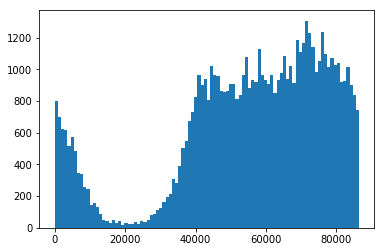

In [4]:
import matplotlib.pyplot as plt
times = [(msg['created_at'] - 5 * 60 * 60) % 86400 for msg in msgs]
plt.hist(times, bins = (24 * 60) // 15)
plt.show()

Before running data based on users, we need to figure out all the users in this group. GroupMe reports this in two ways: name and user_id. The 'name' refers to the nickname which can be changed, and 'user_id' is linked to the specific user and cannot be changed. Because we want to connect all of a user's posts with all of their nicknames, we will use user_id for all analysis and simply keep a dictionary of sender_id -> name based on the first message posted by that user, because that first message is likely to be made using their real name.

First, to get a general idea of the data, let's look at the users that post the most. This is an easy task and can be verified from your personal knowledge of the group chat.

In [5]:
from collections import Counter
# Count the number of times a user ID posts
counter = Counter(msg['user_id'] for msg in msgs)
# This method conveniently sorts them in descending order
counts = counter.most_common()
# For every sender_id, find the first message they sent and record the name
users = {}
for user,count in counts:
    first_msg = next(msg for msg in msgs[::-1] if msg['user_id'] == user)
    users[user] = first_msg['name']
# Print the top ten users and their number of messages.
for user,count in counts[:10]:
    print(users[user] + ": " + str(count))
    
# Print some other data about the group.
print()
print('Number of users ever in the group: ' + str(len(users)))

Leroy Khalifa: 3533
Alex Kent: 2475
Nolan Hiehle: 2370
Adam Tucker: 2244
GroupMe: 2122
Matt Briselli: 1951
Steven Palmer: 1671
Jordan Green: 1509
Jess Chernak: 1502
Luca Damasco: 1408

Number of users ever in the group: 170


One user that may appear in the top 10 is GroupMe. This "user" posts all messages relating to users being added or removed, and other actions like changing the name of the group.


In addition, it would be useful to know how many likes each message has. To know this, we must use the 'favorited_by' key which is a list containing every user that has favorited the message. We will add an additional key-value pair to each message for easy retrieval of the number of likes.

In [6]:
for msg in msgs:
    msg['likes'] = len(msg['favorited_by'])

Now we can begin analysis. A simple query might be, "Whose comments get the most likes on average?" Therefore, for each user ID, we should find the sum of likes of their messages and divide by the number of messages they have. Because of the data we have already collected, this is relatively simple.

In [7]:
avg_likes = {}
# For every user ID, sum all their likes and divide by the number of messages they have sent
for user_id, count in counts:
    s = sum(msg['likes'] for msg in msgs if msg['user_id'] == user_id)
    avg_likes[user_id] = s / count
# Sort the data and print the top 10 most liked users per message
sorted_likes = sorted(avg_likes, key=lambda x: avg_likes[x], reverse=True)
for x in sorted_likes[:10]:
    print(users[x] + ": " + str(avg_likes[x]))
# Print average number of likes per message to verify rest of data
print()
print('Average overall:')
print(sum(msg['likes'] for msg in msgs) / len(msgs))

Adam Kor: 14.5
Mark Tamvakis: 14.0
Andrew Conlon: 9.0
Alex Devienne: 8.78688524590164
Eddie Dryer: 6.0
Raz Golden: 6.0
Grant Campfield: 5.247232472324724
James Orr: 4.4
Brandon Pek: 4.25
Dan Barychev: 4.105263157894737

Average overall:
1.8749028497409326


It would also be interesting to see what types of content the users of this GroupMe prefer (inferred by what they click 'like' on). For example, there could be a difference between posts that have images, or posts that are of shorter or longer length. Let us investigate.

In [8]:
def has_image(msg):
    return msg['attachments'] and any(att['type'] == 'image' for att in msg['attachments'])

images = [msg for msg in msgs if has_image(msg)]
non_images = [msg for msg in msgs if not has_image(msg)]
images_likes = sum(msg['likes'] for msg in images)
non_images_likes = sum(msg['likes'] for msg in non_images)
print('Average likes per message with image: ' + str(images_likes / len(images)))
print('Average likes per message without image: ' + str(non_images_likes / len(non_images)))

Average likes per message with image: 7.526821705426356
Average likes per message without image: 1.5635090117024002


This is a very significant result. In this data set, messages with images have on average ~6 more likes than messages without images.

Let's check out the users that post images often. Compare this to the list of users that post often.

In [9]:
most_image = Counter(msg['user_id'] for msg in msgs if has_image(msg)).most_common()
for user,count in most_image[:10]:
    print(users[user] + ': ' + str(count))

Leroy Khalifa: 303
Nolan Hiehle: 237
Matt Briselli: 208
Will Koshut: 146
Luca Damasco: 105
John B: 97
Anthony Comport: 89
Jordan Green: 89
Sebastian Murati: 76
Drew Dates: 75


Each message also has a list of users who have liked it. We can analyze whose messages a user is most likely to "like". For each user, we will print the top three users whose messages they are most likely to appreciate.

In [10]:
for user in users:
    # for every user, get the messages they favorited and count by which user sent the message
    most_liked = Counter(msg['user_id'] for msg in msgs if user in msg['favorited_by']).most_common()
    if (most_liked):
        top_three = [users[x[0]] for x in most_liked[:3]]
        print(users[user] + ": " + ', '.join(top_three))

Leroy Khalifa: Nolan Hiehle, Matt Briselli, Alex Kent
Alex Kent: Nolan Hiehle, Jess Chernak, Matt Briselli
Nolan Hiehle: Adam Tucker, Leroy Khalifa, Levi Soler
Adam Tucker: Leroy Khalifa, Nolan Hiehle, Steven Palmer
Matt Briselli: Jordan Green, Matt Briselli, Anthony Comport
Steven Palmer: Adam Tucker, Nolan Hiehle, Leroy Khalifa
Jordan Green: Matt Briselli, Jess Chernak, Kevin Chen
Jess Chernak: Matt Briselli, Jordan Green, Anthony Comport
Luca Damasco: Jordan Green, Leroy Khalifa, Matt Briselli
Isaac Barreto: Leroy Khalifa, Matt Briselli, Alex Kent
Sebastian Murati: Leroy Khalifa, Adam Tucker, Jess Chernak
Zach Newman: Nolan Hiehle, Leroy Khalifa, Adam Tucker
Aaron Gutierrez: GroupMe, Adam Tucker, Leroy Khalifa
John B: Levi Soler, Leroy Khalifa, Nolan Hiehle
Will Koshut: Adam Tucker, Joshua Baiad, Leroy Khalifa
Joshua Baiad: Jordan Green, Alex Kent, Luca Damasco
Eric Mendez: Nolan Hiehle, Steven Palmer, Adam Tucker
Levi Soler: Nolan Hiehle, Adam Tucker, John B
Steve Sontag: Adam Tuck

You will probably notice a lot of repeats of the top 10 posting users. This is because this data is just a sum of the likes a user has given another user. 

However, there are two problems with this approach. We are not controlling for how many likes each person gets per message, and we are not controlling for many messages they have sent. If we want to find each user's bias in liking other users' messages, we must divide by number of messages and average likes per message in order to adjust for them.

In [11]:
like_list = {}
for user in users:
    # for every user, get the messages they favorited and count by which user sent the message
    most_liked = Counter(msg['user_id'] for msg in msgs if user in msg['favorited_by']).most_common()
    # now, divide by number of messages per user and likes per message to find user bias
    adjusted = [(user, count / (counter[user] * avg_likes[user])) for user,count in most_liked]
    most_liked = sorted(adjusted, key=lambda x: x[1], reverse=True)
    if most_liked:
        top_three = [users[x[0]] for x in most_liked[:3]]
        print(users[user] + ": " + ', '.join(top_three))
    like_list[user] = most_liked

Leroy Khalifa: Jason Escalante, Fabrice Demière, Derek Lessard
Alex Kent: Andrew Aisosa Orobator, Sahil Abraham, Dee Dick
Nolan Hiehle: Gabe Brower, Harry Xu, Max Schussler
Adam Tucker: Christian Waitforit Pederson, Sudeep Raj, Jake Baldwin
Matt Briselli: Raz, Daniel Nelson, Andrew Aisosa Orobator
Steven Palmer: Dee Dick, Mark Tamvakis, Sudeep Raj
Jordan Green: Varun Kohli, Sebastian Käser, Will Records
Jess Chernak: Renzo Bautista, Eddie Dryer, Sebastian Käser
Luca Damasco: Nick Gasbarro, Guy de Bree, Nick Frollini
Isaac Barreto: Nick Gasbarro, Andrew Aisosa Orobator, Fabrice Demière
Sebastian Murati: Rishi, Derek Lessard, Yash Palod
Zach Newman: Will Records, Carter Appleton, Sahil Abraham
Aaron Gutierrez: Jason Escalante, Tim Brown, Austin Wang
John B: Harry Xu, Txanton B, Clement Wong
Will Koshut: Dee Dick, Joshua Baiad, Achal Channarasappa
Joshua Baiad: Rishi, Renzo Bautista, Carter Appleton
Eric Mendez: Dee Dick, Zo, Richard Zhao
Levi Soler: Sahil Abraham, Mark Tamvakis, Bujji Se

Now we have arrived at data that can give us a rudimentary idea of a relationship in the context of GroupMe. The assumption is that if two users are friends, they are more likely to like each other's messages versus the rest of the group. We will print two users as 'friends' if they are in each other's top 3 liked message lists.

We will use itertools.combinations to easily avoid looping over the same pair of users twice.

In [12]:
from itertools import combinations
for u1, u2 in combinations(users, 2):
    # If u2 is in the top 3 most-liked for u1
    u1_likes_u2 = any(u2 == x[0] for x in like_list[u1][:3])
    # If u1 is in the top 3 most-liked for u2
    u2_likes_u1 = any(u1 == x[0] for x in like_list[u2][:3])
    if  u1_likes_u2 and u2_likes_u1:
        print(users[u1] + ", " + users[u2])

Matt Briselli, Daniel Nelson
Jordan Green, Sebastian Käser
Jordan Green, Will Records
Jess Chernak, Renzo Bautista
Isaac Barreto, Fabrice Demière
Eric Mendez, Dee Dick
Kevin Chen, Zack Furman
Ivan Zhang, David Bang
Alexander Chisolm, Jake Kushner
Sameer Dhavalikar, Anav Behl
Tushar Chetal, Angus Fung
Shyam Raghavan, Mihir Yerande
Sourav Panda, Andrew Conlon
Jake Helmers, Evan Finkelstein
Leon Ji, Derek Lessard
Please Tread On Me, Gabe Brower
Sudeep Raj, Yash Palod
Corey Emery, Brandon Pek
Ian Go, Advaya Krishna
Jackson Gallagher, Mike Hankowsky
Shasvat Jawahar, Max Schussler
Ian Lo, Mark Tamvakis


We can also analyze another indicator of a user's activity in the group message: mentions. Whereas likes could be possibly more related to if users find each others' posts or humor funny, mentions could possibly show more of a real-life relationship because users are conducting a conversation with each other within the group message.

In [13]:
mentions = {user: 0 for user in users}
for msg in msgs:
    if msg['attachments'] and any(att['type'] == 'mentions' for att in msg['attachments']):
        mention_att = next(att for att in msg['attachments'] if att['type'] == 'mentions')
        ids = mention_att['user_ids']
        for user in ids:
            if user in mentions.keys():
                mentions[user] += 1
mentions_sorted = sorted(mentions.items(), key=lambda x: x[1], reverse=True)           
for tup in mentions_sorted[:10]:
    print(users[tup[0]] + ": " + str(mentions[tup[0]]))

Adam Tucker: 166
Leroy Khalifa: 160
Nolan Hiehle: 156
John B: 140
Alex Kent: 128
Joshua Baiad: 119
Zach Newman: 117
Steven Palmer: 108
Eric Mendez: 100
Nick Kosarek: 96


We can do the same thing with mentions that we did with likes. We will figure out, for each user, which users they mention most often. If two users mention each other often, we assume that they have some sort of relationship, whether it is a friendship or based on leadership positions such as president and vice-president.

In [14]:
def get_mentions(msg):
    # If msg has attachments and one of the attachments is mentions
    if msg['attachments'] and any(att['type'] == 'mentions' for att in msg['attachments']):
        mention_att = next(att for att in msg['attachments'] if att['type'] == 'mentions')
        return mention_att['user_ids']
    else:
        return None

mention_list = {}
for user in users:
    mentioned_per_message = [get_mentions(msg) for msg in msgs if user == msg['user_id']]
    # Remove Nones
    mentioned_per_message = [x for x in mentioned_per_message if x != None]
    # Flatten the list.
    mentioned_per_message = [x for msg in mentioned_per_message for x in msg]
    most_mentioned = Counter(mentioned_per_message).most_common()
    mention_list[user] = [x[0] for x in most_mentioned]
for x in mention_list:
    print(users[x] + ": " + ','.join(users[y] for y in mention_list[x][:3]))

Leroy Khalifa: Alex Kent,Nolan Hiehle,Ashwin Sekar
Alex Kent: Joshua Baiad,Steven Palmer,Adam Tucker
Nolan Hiehle: John B,Eric Mendez,Alex Kent
Adam Tucker: Leroy Khalifa,Nolan Hiehle,Will Koshut
GroupMe: 
Matt Briselli: Achal Channarasappa,Ryan McKinney,Sebastian Murati
Steven Palmer: Sung Jun Hong,Adam Tucker,Bujji Setty
Jordan Green: 
Jess Chernak: Alex Kent,Isaac Barreto,Aaron Perley
Luca Damasco: Leroy Khalifa,Anthony Ko,Xavier Apostol
Isaac Barreto: Eric Mendez,Sebastian Murati,Leroy Khalifa
Sebastian Murati: Joshua Baiad,Eric Mendez,Sahil Abraham
Zach Newman: Joshua Baiad,Nolan Hiehle,John B
Aaron Gutierrez: Will Koshut,Adam Tucker,Zach Newman
John B: Leroy Khalifa,Alex Oh,Xavier Apostol
Will Koshut: Adam Tucker,Achal Channarasappa,Aaron Gutierrez
Joshua Baiad: Zach Newman,Alex Kent,Ben Yang
Eric Mendez: Zo,Nolan Hiehle,Alex Kent
Levi Soler: John B,Zo,Nolan Hiehle
Steve Sontag: John B,Xavier Apostol,Drew Dates
Ashwin Sekar: Alex Oh,John B,Siddhant Madhuk
Abhi Kelkar: Matt Brisel

Now that we have the users most likely to be mentioned by every user, we can now check for relationships between these users based on mentions. We will print a pair of users if they are both in the top 3 of each other's mention lists.

In [15]:
for u1, u2 in combinations(users, 2):
    # If u2 mentions u1 and u1 mentions u2
    if u1 in mention_list[u2][:3] and u2 in mention_list[u1][:3]:
        print(users[u1] + ", " + users[u2])

Alex Kent, Joshua Baiad
Nolan Hiehle, Eric Mendez
Adam Tucker, Will Koshut
Zach Newman, Joshua Baiad
Aaron Gutierrez, Will Koshut
John B, Xavier Apostol
Eric Mendez, Zo
Ryan McKinney, Camilo Estrada
Ryan McKinney, Charlie Raycraft
Nick Kosarek, John Pyun
Steven Pаlmer, Zo
Terence Huang, Zo
Yash Palod, Sahil Abraham
Pankaj Bhojwani, Nikhil Choudhary


Overall, this has been a basic analysis of user communication using timestamp data, content, number of likes, and number of mentions. This barely scratches the surface of social network analysis, but I hope it has given you a good idea of the relationships that can be exposed using data from daily interactions. Over time, users form patterns around when they post, who they mention, and whose messages they like, without even realizing it. This data can be downloaded and used for good and potentially bad purposes. 

If you are interested in learning more about how GroupMe data can be analyzed, check this link: https://groupmeanalysis.com/.

If you are interested in analyzing more complex data about messages, such as sentiment analysis, check out TextBlob: https://pypi.python.org/pypi/textblob. This package allows you to analyze messages for sentiment, which could be used to determine the average sentiment of a user's messages, which could be compared for different groups or when they mention different users. 

If you want a more visual analysis of a user's or group's messages, consider using a word cloud package such as https://github.com/amueller/word_cloud. This will allow you to see what words are used by a user, which could again be compared when they message different users or groups to see how their language changes depending on context.

Thanks for reading!